In [3]:
import torch
from torchtext import data
from torchtext import datasets
import random
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

In [2]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

# download data from PyTorch

In [3]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [4]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [5]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [6]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

# define model classes

In [46]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [8]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        # unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))

# training

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [11]:
criterion = nn.BCEWithLogitsLoss()

In [13]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [15]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


# LSTM results

In [12]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM, 
             EMBEDDING_DIM, 
             HIDDEN_DIM, 
             OUTPUT_DIM, 
             N_LAYERS, 
             BIDIRECTIONAL, 
             DROPOUT, 
             PAD_IDX)

In [40]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


In [41]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.8936, -1.2402,  0.4131,  ...,  0.0515,  0.4817,  1.1054],
        [-0.1386,  0.1180,  0.3534,  ...,  0.1226,  0.5973, -0.1702],
        [-0.0786,  0.0541, -0.0993,  ...,  0.2565, -0.1874, -0.4428]])

In [42]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.8936, -1.2402,  0.4131,  ...,  0.0515,  0.4817,  1.1054],
        [-0.1386,  0.1180,  0.3534,  ...,  0.1226,  0.5973, -0.1702],
        [-0.0786,  0.0541, -0.0993,  ...,  0.2565, -0.1874, -0.4428]])


In [43]:
optimizer = optim.Adam(model.parameters())

In [44]:
model = model.to(device)
criterion = criterion.to(device)

In [22]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm_model_IMDB.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 128m 3s
	Train Loss: 0.682 | Train Acc: 54.99%
	 Val. Loss: 0.689 |  Val. Acc: 56.34%
Epoch: 02 | Epoch Time: 117m 19s
	Train Loss: 0.682 | Train Acc: 55.29%
	 Val. Loss: 0.786 |  Val. Acc: 52.60%
Epoch: 03 | Epoch Time: 110m 52s
	Train Loss: 0.651 | Train Acc: 61.35%
	 Val. Loss: 0.535 |  Val. Acc: 73.95%
Epoch: 04 | Epoch Time: 111m 58s
	Train Loss: 0.501 | Train Acc: 75.75%
	 Val. Loss: 0.439 |  Val. Acc: 79.39%
Epoch: 05 | Epoch Time: 109m 45s
	Train Loss: 0.344 | Train Acc: 85.44%
	 Val. Loss: 0.330 |  Val. Acc: 86.03%


In [23]:
model.load_state_dict(torch.load('lstm_model_IMDB.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.364 | Test Acc: 84.77%


# plot results

In [4]:
train_loss_lstm = [0.682, 0.682, 0.651, 0.501, 0.344]
train_acc_lstm = [54.99, 55.29, 61.35, 75.75, 85.44] 
val_loss_lstm = [0.689, 0.786, 0.535, 0.439, 0.330]
val_acc_lstm = [56.34, 52.60, 73.95, 79.39, 86.03]

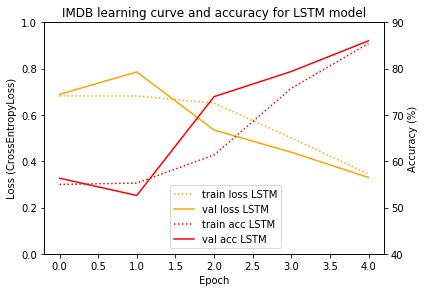

In [5]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (CrossEntropyLoss)')
ax1.plot(train_loss_lstm, label="train loss LSTM", color="orange", linestyle=':')
ax1.plot(val_loss_lstm, label="val loss LSTM", color="orange")
ax1.set_ylim(0.0, 1.0)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)')  # we already handled the x-label with ax1
ax2.plot(train_acc_lstm, label="train acc LSTM", color="red", linestyle=':')
ax2.plot(val_acc_lstm, label="val acc LSTM", color="red")
ax2.set_ylim(40, 90)
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.legend(loc=(0.4, 0.15))

plt.title("IMDB learning curve and accuracy for LSTM model")

plt.show()

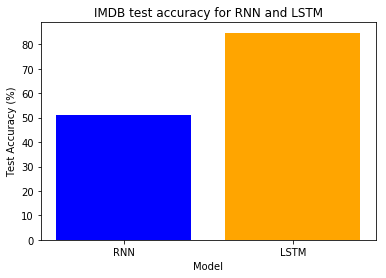

In [114]:
acc = {"RNN": 50.99, "LSTM": 84.77}
plt.xlabel("Model")
plt.ylabel("Test Accuracy (%)")
plt.title("IMDB test accuracy for RNN and LSTM")
plt.bar(range(len(acc)), list(acc.values()), color=('blue','orange'), align='center')
plt.xticks(range(len(acc)), list(acc.keys()))
plt.show()

# extra

In [78]:
import spacy
nlp = spacy.load('en')

In [79]:
def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [83]:
model.load_state_dict(torch.load('lstm_model_IMDB.pt'))

In [84]:
predict_sentiment(model, "This film is terrible")

0.013534318655729294

In [85]:
predict_sentiment(model, "This film is great")

0.9947775602340698